In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
import skimage.io as io
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [15]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
#stacks multipel operations
preprocess = transforms.Compose([
    transforms.ToPILImage(), #converts to PIL image
    transforms.Resize((224, 224)), #input size for vgg (standard)
    transforms.ToTensor(),
    normalise
])

#to get the rgb values again
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])

In [12]:
vgg = models.vgg16(pretrained=True)
# vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [21]:
def dd_helper(image, layer, iterations, lr):
    #after preprocess we getthe image as 3 224 224 thn using unsques we get 1 3 224 224
    inp = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    vgg.zero_grad()
    
    for i in range(iterations):
        out = inp
        for j in range(layer):
            out = modulelist[j + 1](out) #passing through all teh layers
        loss = out.norm() #l2 norm to maximize
        loss.backward()
        inp.data = inp.data + lr * inp.grad.data #gradient ascend
    
    inp = inp.data.squeeze() #we get the rgb image 3,224,224 (rgb,rows,col)
    inp.transpose_(0, 1) #swaps the dimenssions 224,3,224
    inp.transpose_(1, 2) # 224,224,3
    inp = np.clip(deprocess(inp), 0, 1) #clips the values returned from deprocess in btw 0 and 1 anything less than 0 will be 0 and thingmore than 1 will be one
    im = np.uint8(inp * 255)
    
    return im

In [22]:
def deep_dream(image, layer, iterations, lr):
    img_res = dd_helper(image, layer, iterations, lr)
    img_res = resize(img_res, image.shape)
    
    plt.imshow(img_res)
    return img_res

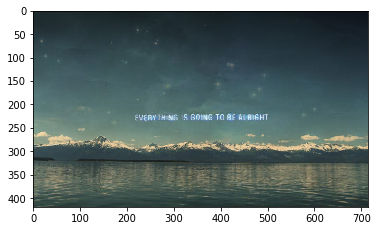

In [28]:
# im = io.imread('../../data/2007_000559.jpg')
im = io.imread('../images/image3.jpg')
# im = np.uint8(255*np.random.random((500, 500, 3)))
plt.imshow(im)

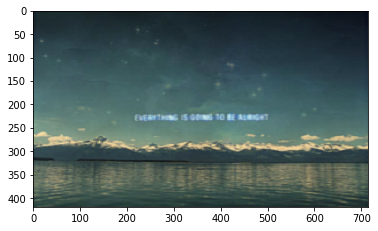

In [33]:
s5 = deep_dream(im, 2, 5, 0.3)